In [5]:
#%autoreload

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import yaml
from tqdm import tqdm, trange
import os
import matplotlib.pyplot as plt
from sklearn.metrics import (
    f1_score, 
    balanced_accuracy_score, 
    confusion_matrix,
    ConfusionMatrixDisplay, 
    accuracy_score,
    classification_report
)
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

from torch.utils.tensorboard import SummaryWriter
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import yaml
import os

from sklearn.metrics import (
    f1_score, 
    balanced_accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns 
from lightgbm import LGBMClassifier
pd.set_option('display.max_columns', None)

from cnn_utils import (
    PTB_Dataset,
    EarlyStopping,
    set_all_seeds,
    train_and_validate,
    test,
)


In [3]:
os.getcwd()

'c:\\Users\\pauls\\Documents\\ML4Healthcare\\project2\\task2\\finetuning'

In [2]:
import os


os.getwd()



FileNotFoundError: [WinError 3] Das System kann den angegebenen Pfad nicht finden: 'Gamma1024/ML4Healthcare/project2/task2/finetuning'

In [2]:
#%load_ext autoreload

In [5]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SEED = 42

TRAIN_BATCH_SIZE = 32
VAL_BATCH_SIZE = 256
TEST_BATCH_SIZE = 256

N_EPOCHS=10


In [7]:
path= r'C:\Users\pauls\Desktop\Studium\Machine Learning for Health Care\Projekt 2\project2_TS_input'
#path = "../../data"

# Load data
train_df = pd.read_csv(os.path.join(path, 'ptbdb_train.csv'), header=None)
test_df = pd.read_csv(os.path.join(path, 'ptbdb_test.csv'), header=None)

X_train_full = train_df.iloc[:, :-1].to_numpy()
y_train_full = train_df.iloc[:, -1].to_numpy()

X_test = test_df.iloc[:, :-1].to_numpy()
y_test = test_df.iloc[:, -1].to_numpy()

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=SEED
)



In [54]:
print(train_df.shape)
print(test_df.shape)

(11641, 188)
(2911, 188)


In [22]:
X_train.shape


(9312, 187)

### Reading in the embeddings

In [42]:
path= r'C:\Users\pauls\Desktop\Studium\Machine Learning for Health Care\Projekt 2\project2_TS_input'

emb_ptb_train_Q1 = np.load(path+'\\embeddings_ptb_train_Q1.npy')
emb_ptb_test_Q1 = np.load(path+'\\embeddings_ptb_test_Q1.npy')
emb_ptb_train_Q2 = np.load(path+'\\embeddings_ptb_train_Q2.npy')
emb_ptb_test_Q2 = np.load(path+'\\embeddings_ptb_test_Q2.npy')

In [43]:
#Standardizing the embeddings:

def stand(df):
    df_new = (df-df.mean())/df.std()
    return pd.DataFrame(df_new)

emb_ptb_train_Q1 = stand(emb_ptb_train_Q1)
emb_ptb_test_Q1 = stand(emb_ptb_test_Q1)
emb_ptb_train_Q2 = stand(emb_ptb_train_Q2)
emb_ptb_test_Q2 = stand(emb_ptb_test_Q2)


### Gradient boosting with the Q1 Encoder

In [44]:
boost_no_feat_eng_Q1 =LGBMClassifier(
    random_state=42,
    verbose=-1,
    n_jobs=-1
)
boost_no_feat_eng_Q1.fit(emb_ptb_train_Q1, y_train_full)

y_preds = boost_no_feat_eng_Q1.predict(emb_ptb_test_Q1)

LGBMClassifier(n_jobs=-1, random_state=42, verbose=-1)

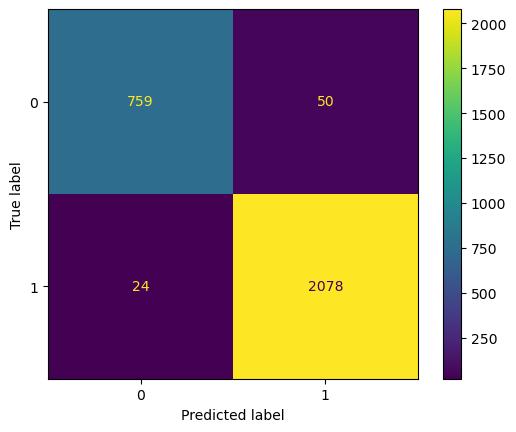

In [46]:
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()

In [47]:
# calculate precision and recall:
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print(f"Test accuracy: {accuracy_score(y_test, y_preds):.6f}")
print(f"Test balanced accuracy: {balanced_accuracy_score(y_test, y_preds):.6f}")
print(f"Test f1 score: {f1_score(y_test, y_preds):.6f}")
print(f"Test precision: {precision:.6f}")
print(f"Test recall: {recall:.6f}")

Test accuracy: 0.974579
Test balanced accuracy: 0.963389
Test f1 score: 0.982506
Test precision: 0.976504
Test recall: 0.988582


In [27]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96       809
         1.0       0.98      0.99      0.98      2102

    accuracy                           0.98      2911
   macro avg       0.98      0.97      0.97      2911
weighted avg       0.98      0.98      0.98      2911



### Gradient boosting with the Q1 Encoder

In [52]:
print(emb_ptb_train_Q1.shape)
print(emb_ptb_train_Q2.shape)
print(y_train_full.shape)

(11641, 256)
(16808, 256)
(11641,)


In [48]:
boost_no_feat_eng_Q2 =LGBMClassifier(
    random_state=42,
    verbose=-1,
    n_jobs=-1
)

boost_no_feat_eng_Q2.fit(emb_ptb_train_Q2, y_train_full)

y_preds = boost_no_feat_eng_Q2.predict(emb_ptb_test_Q2)

LightGBMError: Length of labels differs from the length of #data

# MLP output layers

In [56]:
ptb_train_loader = DataLoader(
    PTB_Dataset(emb_ptb_train_Q1, y_train_full),
    batch_size=32,
    shuffle=True,
    pin_memory=True,
    num_workers=0,
)
ptb_test_loader = DataLoader(
    PTB_Dataset(emb_ptb_testn_Q1, y_test),
    batch_size=32,
    shuffle=False,
    pin_memory=True,
    num_workers=0,
)

NameError: name 'PTB_Dataset' is not defined

In [55]:
class MLP(nn.Module):
    def __init__(
        self,
        in_size: int,
        out_size: int = 2,
        hidden_profile: list[int] = [1024],
        dropout: float = 0.0,
    ):
        super(MLP, self).__init__()

        self.layers = []
        # add first hidden layer
        self.layers.append(nn.Linear(in_size, hidden_profile[0]))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(dropout))

        # loop through hidden profile and add hidden layers
        for hidden_in_size, hidden_out_size in zip(
            hidden_profile[:-1], hidden_profile[1:]
        ):            
            self.layers.append(nn.Linear(hidden_in_size, hidden_out_size))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout))

        # add output layer
        self.layers.append(nn.Linear(hidden_profile[-1], out_size))

        self.nn = nn.Sequential(*self.layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.nn(x)
        return x  # Squeeze the output here to ensure correct shape for BCEWithLogitsLoss
    

model = MLP(
    in_size=256,
    out_size=2,
    hidden_profile=[512, 256, 128, 64, 32],
    dropout=0.3
).to(DEVICE)


#TODO Check out HODL for step C, i.e. freezing the Encoder part for the first e.g. 20 epochs, only training the output layers and then after some point start training them both together

In [ ]:
train_and_validate(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    n_epochs=N_EPOCHS,
    ES=ES,
    scheduler=scheduler,
    summary_writer=writer,
    device=DEVICE,
    use_penalized_BCE=False
)

test_loss, test_f1_score, balanced_accuracy, model_probs, y_true = test(
    model=model,
    test_loader=test_loader,
    criterion=criterion,
    device=DEVICE,
)